# Chatbot with message summarization & external DB memory 

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of tricks for trimming or filtering messages in graph state. 

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

## Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases. 

Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_groq

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database. 
 
If we supply `":memory:"` it creates an in-memory Sqlite database.

In [3]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

But, if we supply a db path, then it will create a database for us!

In [4]:
# Create directory if it doesn't exist
!mkdir -p state_db

# Connect to local db (will create if doesn't exist)
db_path = "state_db/groq_chatbot.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [5]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Let's re-define our chatbot with Groq.

In [6]:
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

# Initialize Groq with Llama model
model = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Now, we just re-compile with our sqlite checkpointer.

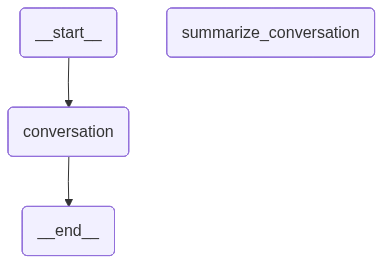

In [7]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times. 

In [8]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Lance! It's nice to meet you. Is there something I can help you with or would you like to chat?
================================== Ai Message ==================================

Your name is Lance.
================================== Ai Message ==================================

A 49ers fan, eh? That's great! The San Francisco 49ers have a rich history in the NFL, with five Super Bowl wins and a loyal fan base. Who's your favorite player, past or present? Joe Montana, Jerry Rice, or maybe someone from the current roster like George Kittle or Deebo Samuel?


Let's confirm that our state is saved locally.

In [9]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
print("Current state:")
print(f"Number of messages: {len(graph_state.values['messages'])}")
print(f"Summary: {graph_state.values.get('summary', 'No summary yet')}")
graph_state

Current state:
Number of messages: 6
Summary: No summary yet


StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='b503b995-ce7b-437c-846a-71582cfe7d1a'), AIMessage(content="Hello Lance! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 40, 'total_tokens': 66, 'completion_time': 0.043417154, 'prompt_time': 0.001978755, 'queue_time': 0.05695655, 'total_time': 0.045395909}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9e1e8f8435', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--c8da3759-a8dc-4526-84e6-27783db6cad6-0', usage_metadata={'input_tokens': 40, 'output_tokens': 26, 'total_tokens': 66}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='2ce13484-7301-446e-92d6-c99dd31271b0'), AIMessage(content='Your name is Lance.',

### Persisting state

Using database like Sqlite means state is persisted! 

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.

Let's test this by creating a new connection and loading the state.

In [10]:
# Simulate restarting by creating a new connection and memory object
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

# Reconnect to the existing database
db_path = "state_db/groq_chatbot.db"
new_conn = sqlite3.connect(db_path, check_same_thread=False)
new_memory = SqliteSaver(new_conn)

# Recreate the graph with the new memory
new_graph = workflow.compile(checkpointer=new_memory)

# Load the state from thread 1
config = {"configurable": {"thread_id": "1"}}
loaded_state = new_graph.get_state(config)
print("\n=== Loaded state from persistent storage ===")
print(f"Number of messages: {len(loaded_state.values['messages'])}")
print(f"Summary: {loaded_state.values.get('summary', 'No summary yet')}")
loaded_state


=== Loaded state from persistent storage ===
Number of messages: 6
Summary: No summary yet


StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='b503b995-ce7b-437c-846a-71582cfe7d1a'), AIMessage(content="Hello Lance! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 40, 'total_tokens': 66, 'completion_time': 0.043417154, 'prompt_time': 0.001978755, 'queue_time': 0.05695655, 'total_time': 0.045395909}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9e1e8f8435', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--c8da3759-a8dc-4526-84e6-27783db6cad6-0', usage_metadata={'input_tokens': 40, 'output_tokens': 26, 'total_tokens': 66}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='2ce13484-7301-446e-92d6-c99dd31271b0'), AIMessage(content='Your name is Lance.',

### Continue the conversation

Now let's continue the conversation from where we left off!

In [11]:
# Continue the conversation using the persistent state
config = {"configurable": {"thread_id": "1"}}

input_message = HumanMessage(content="Tell me about their quarterback!")
output = new_graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

print("\n=== Updated state ===")
updated_state = new_graph.get_state(config)
print(f"Number of messages: {len(updated_state.values['messages'])}")
print(f"Summary exists: {bool(updated_state.values.get('summary'))}")

================================== Ai Message ==================================

You're probably thinking of Brock Purdy or Trey Lance (no relation, I assume?). The 49ers have had a bit of a quarterback carousel in recent years, but I'll give you a brief rundown on their current QB situation.

Brock Purdy is the current starting quarterback for the 49ers. He's a young quarterback who had a remarkable rookie season in 2022, leading the team to the NFC Championship game. Purdy is known for his accuracy, poise, and ability to extend plays with his feet.

Trey Lance, on the other hand, is a talented young quarterback who was drafted by the 49ers with the third overall pick in the 2021 NFL Draft. He's a dual-threat quarterback with a strong arm and impressive athleticism. However, he's struggled with injuries and consistency, which has limited his playing time.

It's worth noting that the 49ers have a strong team around their quarterback, with a stout defense, a solid running game, and a t

### Test Multiple Threads

Let's verify that different threads maintain separate conversations in the database.

In [12]:
# Create a new thread with different conversation
config2 = {"configurable": {"thread_id": "2"}}

input_message = HumanMessage(content="Hi! I'm Sarah and I love basketball")
output = new_graph.invoke({"messages": [input_message]}, config2) 
print("\n=== Thread 2 (Sarah) ===")
for m in output['messages'][-1:]:
    m.pretty_print()

# Verify thread 1 still has Lance's conversation
config1 = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="What's my favorite team again?")
output = new_graph.invoke({"messages": [input_message]}, config1) 
print("\n=== Thread 1 (Lance) ===")
for m in output['messages'][-1:]:
    m.pretty_print()


=== Thread 2 (Sarah) ===
================================== Ai Message ==================================

Hi Sarah! It's great to meet you! Basketball is an exciting sport, and there are so many talented players and teams to follow. Are you a fan of a particular team, like the NBA or WNBA, or do you enjoy playing basketball yourself?

=== Thread 1 (Lance) ===
================================== Ai Message ==================================

Your favorite team is the San Francisco 49ers! You mentioned that earlier in our conversation. Are you excited about their upcoming season?
